# Comentarios sobre la practica 1
Dificultades: La mayor dificultad en esta primera parte de la práctica final ha sido el obtener un data frame conjunto con los datos de las 3 cotizaciones. El hecho de que las fechas fueran unixTime y quisieramos obtener una única cotización por fecha cuando había varias, ha sido lo más complicado.
En la creación de los gráficos también he tenido que consultar en internet para conseguir el gráfico deseado
La parte que me ha quedado por realizar ha sido resaltar el valor máximo de la cotización en el gráfico de la serie temporal.

# Prueba de evaluacion 1
## Parte 1 
En esta primera parte trabajaremos con datos de cotización de Bitcoin. En esta página:
[http://www.coindesk.com/price/]
Se pueden descargar los valores de “cierre” de esa cotización en dólares en diferentes
mercados “exchanges” mediante el botón “Export” del gráfico, como CSV.

Descargamos los ficheros de la web:
![](recursos/ficheros.jpg)


Cargamos las librerias que vamos a utilizar:

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
from datetime import datetime, date, timedelta
import ggplot as g
from numpy import convolve 
import matplotlib.pyplot as plt

Leemos los ficheros csv

In [2]:
bc_EUR = pd.read_csv("datos/anxhkEUR.csv")
bc_GBP = pd.read_csv("datos/anxhkGBP.csv") 
bc_USD = pd.read_csv("datos/anxhkUSD.csv")
#Damos nombre a las columnas, ya que el csv viene sin encabezado
bc_EUR.columns=['date','price_EUR','amount_EUR']
bc_GBP.columns=['date','price_GBP','amount_GBP']
bc_USD.columns=['date','price_USD','amount_USD']
bc_EUR.head(4)

,date,price_EUR,amount_EUR
0,1392570616,484.522079,0.020907
1,1394464117,459.863573,0.067890
2,1394479269,449.760099,0.040644
3,1395251525,443.000000,0.100000


In [3]:
#Creamos una funcion para convertir la fecha unix time en un timestamp
def cambioFecha_Datetime(unixFec):
   return datetime.fromtimestamp(unixFec)
def cambioFecha_Date(unixFec):
   return date.fromtimestamp(unixFec)

In [4]:
bc_EUR['dateTime']=bc_EUR['date'].apply(cambioFecha_Datetime)
bc_GBP['dateTime']=bc_GBP['date'].apply(cambioFecha_Datetime)
bc_USD['dateTime']=bc_USD['date'].apply(cambioFecha_Datetime)
bc_EUR['date']=bc_EUR['date'].apply(cambioFecha_Date)
bc_GBP['date']=bc_GBP['date'].apply(cambioFecha_Date)
bc_USD['date']=bc_USD['date'].apply(cambioFecha_Date)


In [5]:
bc_EUR.head(4)

,date,price_EUR,amount_EUR,dateTime
0,2014-02-16,484.522079,0.020907,2014-02-16 18:10:16
1,2014-03-10,459.863573,0.067890,2014-03-10 16:08:37
2,2014-03-10,449.760099,0.040644,2014-03-10 20:21:09
3,2014-03-19,443.000000,0.100000,2014-03-19 18:52:05


Vamos a tomar un fichero de datos menor. Para ello vamos a quedarnos con los datos del ultimo año que aparece en el fichero del Euro.
Tomaremos ese intervalo en los otros tres fichero.

In [6]:

max_date_cotiz=bc_EUR['date'].max()
min_date_cotiz=max_date_cotiz-timedelta(days=365)
bc_EUR = bc_EUR[(bc_EUR['date'] >= min_date_cotiz) & (bc_EUR['date'] <= max_date_cotiz)]
bc_GBP = bc_GBP[(bc_GBP['date'] >= min_date_cotiz) & (bc_GBP['date'] <= max_date_cotiz)]
bc_USD = bc_USD[(bc_USD['date'] >= min_date_cotiz) & (bc_USD['date'] <= max_date_cotiz)]


Nos vamos a quedar con la hora más alta de cada día para tomarla como hora de cierre.
Después eliminamos la columna dateTime porque ya no la necesitamos

In [7]:
bc_EUR = bc_EUR.sort_values(['date','dateTime'], ascending=True).groupby('date', as_index=False).last()
bc_GBP = bc_GBP.sort_values(['date','dateTime'], ascending=True).groupby('date', as_index=False).last()
bc_USD = bc_USD.sort_values(['date','dateTime'], ascending=True).groupby('date', as_index=False).last()
bc_EUR=bc_EUR.drop('dateTime', axis=1)
bc_GBP=bc_GBP.drop('dateTime', axis=1)
bc_USD=bc_USD.drop('dateTime', axis=1)


In [8]:
#Unimos todos los datos en una única variable
bc_mix=bc_EUR.merge(bc_GBP.merge(bc_USD,how='outer'),on='date',how='outer')
bc_mix.head()

,date,price_EUR,amount_EUR,price_GBP,amount_GBP,price_USD,amount_USD
0,2014-10-10,284.23860,0.5080,223.20914,0.5080,355.00000,0.5080
1,2014-10-11,288.00421,1.9823,226.20936,1.9823,363.64030,1.9823
2,2014-10-12,289.02561,1.0000,227.04461,1.0000,365.00000,1.0000
3,2014-10-13,299.05847,0.0700,236.65719,0.0700,380.65587,0.0700
4,2014-10-14,322.51120,0.0300,256.63958,0.0300,403.99999,0.0300


In [9]:
#indexamos la columna date
bc_mix= bc_mix.set_index(['date'])

In [10]:
#buscamos la fecha con la máxima y mínima cotización
max_date= pd.Series([bc_mix['price_EUR'].idxmax(),bc_mix['price_GBP'].idxmax(),bc_mix['price_USD'].idxmax()]).max()
min_date= pd.Series([bc_mix['price_EUR'].idxmin(),bc_mix['price_GBP'].idxmin(),bc_mix['price_USD'].idxmin()]).min()


In [11]:
print "fecha max cotizacion: "+ str(max_date) + ". Fecha de minima cotizacion: "+ str(min_date)

fecha max cotizacion: 2014-11-13. Fecha de minima cotizacion: 2015-01-14


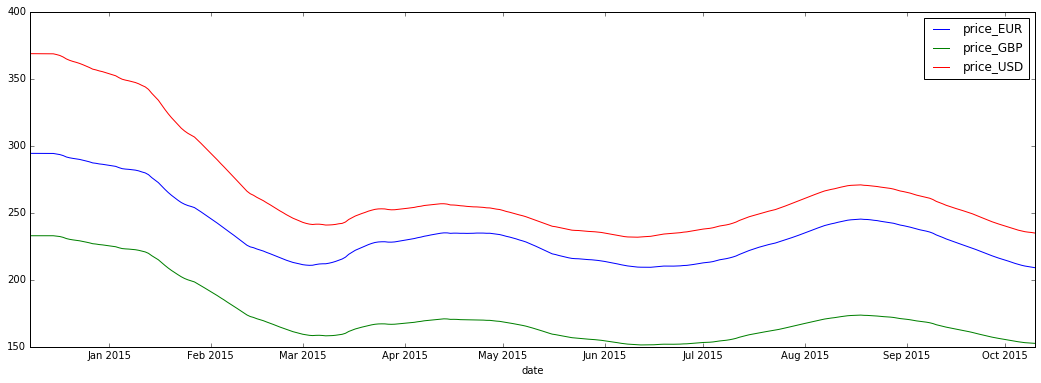

In [26]:
#Calculo de la media movil en una ventana de 60
media_movil_EUR=bc_mix['price_EUR'].rolling(window=60).mean().dropna()
media_movil_GBP=bc_mix['price_GBP'].rolling(window=60).mean().dropna()
media_movil_USD=bc_mix['price_USD'].rolling(window=60).mean().dropna()
#media_movil_EUR.plot(figsize=(15,8))
media_movil=pd.concat([media_movil_EUR, media_movil_GBP, media_movil_USD], axis=1)
media_movil.plot(figsize=(18,6))

Obtenemos la máxima diferencia entre las cotizaciones del bitcoin en euros y dólares y tambien su diferencia media

In [27]:
dif_max=(bc_mix['price_EUR']-bc_mix['price_USD']).abs().max()
dif_media=(bc_mix['price_EUR']-bc_mix['price_USD']).mean()
print "la diferencia media entre la cotizacion en euros y en dólares fue de " + str(dif_media)
print "la máxima diferencia entre la cotización en euros y en dólares fue de " +str(dif_max) 

la diferencia media entre la cotizacion en euros y en dólares fue de -35.1077431389
la máxima diferencia entre la cotización en euros y en dólares fue de 86.24901
